## Recurrent Neural Networks

Recurrent Neural Networks (RNNs) are a type of neural network that are designed to handle sequential data, where the order of the elements matters.. Recurrent neural networks (RNNs) have proven their success in learning from time-series data.

In this chapter, we will use a RNN to learn to predict CO2 concentration levels in the next 5 years. Specifically, the following.

* How to do simple data exploration on time series data
* How to define a RNN model
* How to transfrom time series data to train a sequential model
* How to train a model

In [34]:
import random
import os
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
# Fixing the random seed
fix_random_seed(4321)

## Loading data 

In [35]:
# Section 4.3

import pandas as pd
import requests
import os

def download_data():
    """ This function downloads the CO2 data from 
    https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv
    if the file doesn't already exist
    """
    save_dir = "data"
    save_path = os.path.join(save_dir, 'co2-mm-gl.csv')

    # Create directories if they are not there
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Download the data and save
    if not os.path.exists(save_path):
        url = "https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv"
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
    else:
        print("co2-mm-gl.csv already exists. Not downloading.")
    return save_path

# Downloading the data
save_path = download_data()

# Load the data 
data = pd.read_csv(save_path)
data.head()

co2-mm-gl.csv already exists. Not downloading.


,Date,Decimal Date,Average,Trend
0,1980-01-01,1980.042,338.45,337.83
1,1980-02-01,1980.125,339.15,338.10
2,1980-03-01,1980.208,339.48,338.13
3,1980-04-01,1980.292,339.87,338.25
4,1980-05-01,1980.375,340.30,338.78


In [36]:
# Set the date as the index of the dataframe
data = data.set_index('Date')

In [37]:
data.head()

,Decimal Date,Average,Trend
Date,,,
1980-01-01,1980.042,338.45,337.83
1980-02-01,1980.125,339.15,338.10
1980-03-01,1980.208,339.48,338.13
1980-04-01,1980.292,339.87,338.25
1980-05-01,1980.375,340.30,338.78


## Plotting CO2 concentration over time

<Axes: xlabel='Date'>

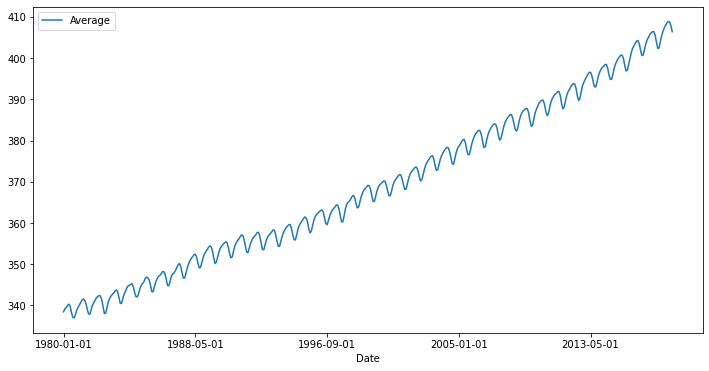

In [38]:
# Plotting the CO2 trend
data[["Average"]].plot(figsize=(12,6))

## Creating the `Average Diff` column

`Average Diff` is computed as,

`Average Diff(t) = Average(t) - Average(t-1)`

In [39]:
data['Average Diff'] = data["Average"] - data['Average'].shift(1).fillna(method='bfill')
data.head()

,Decimal Date,Average,Trend,Average Diff
Date,,,,
1980-01-01,1980.042,338.45,337.83,0.00
1980-02-01,1980.125,339.15,338.10,0.70
1980-03-01,1980.208,339.48,338.13,0.33
1980-04-01,1980.292,339.87,338.25,0.39
1980-05-01,1980.375,340.30,338.78,0.43


<Axes: xlabel='Date'>

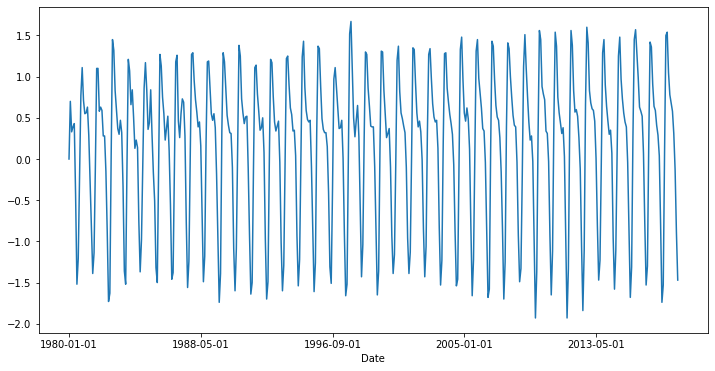

In [40]:
data["Average Diff"].plot(figsize=(12,6))

## Generating time-series data for the model 

In [41]:
import numpy as np

def generate_data(co2_arr, n_seq):
    """Generating data for the model. 
    Input is a matrix of size (n x n_seq) and 
    Output is a vector of size n."""
    
    x, y = [], []
    for i in range(co2_arr.shape[0] - n_seq):
        x.append(co2_arr[i:i+n_seq-1])
        y.append(co2_arr[i+n_seq-1:i+n_seq])
    x = np.array(x).reshape(-1, n_seq-1, 1)
    y = np.array(y)
    return x, y
# Generating the data
x, y = generate_data(data['Average Diff'].values, 13)

# Let's print some data to see what we got

print("Original values: ", data["Average Diff"].values[:20])
print()
i = 0
for xx, yy in zip(x,y):
    print('x: ',xx.ravel(), ' y: ', yy.ravel())
    i += 1
    if i>5: break

Original values:  [ 0.    0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71
  0.55  0.56  0.63  0.29 -0.27 -0.81 -1.39 -1.14]

x:  [ 0.    0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71]  y:  [0.55]
x:  [ 0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55]  y:  [0.56]
x:  [ 0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56]  y:  [0.63]
x:  [ 0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63]  y:  [0.29]
x:  [ 0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63  0.29]  y:  [-0.27]
x:  [-0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63  0.29 -0.27]  y:  [-0.81]


## Defining and training the model

In [42]:
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

K.clear_session()

# Defining the model
rnn = models.Sequential([
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compiling the model

rnn.compile(loss='mse', optimizer='adam')

In [43]:
rnn.fit(x, y, shuffle=True, batch_size=64, epochs=25)

Epoch 1/25
8/8 [==============================] - 0s 3ms/step - loss: 0.4915
Epoch 2/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0675
Epoch 3/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 4/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 5/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 6/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 7/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 8/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 9/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0247
Epoch 10/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 11/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 12/25
8/8 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 13/25
8/8 [==============================] - 0s 2ms/step - loss: 0.

## Predicting using the trained model 

In [44]:
import numpy as np

# Getting the last 12 values from the history to generate the first prediction
history = data["Average Diff"].values[-12:].reshape(1,-1,1)

# To hold the absolute values
true_vals = []

# Holds the very last value in the history
prev_true = data["Average"].values[-1]

# Making predictions for 60 time steps
for i in range(60):
    # Make a single prediction
    p_diff = rnn.predict(history).reshape(1,-1,1)
    
    # Modifying the history so that we have
    history = np.concatenate((history[:,1:,:],p_diff),axis=1)
    # Generate the absolute prediction
    true_vals.append(prev_true + p_diff[0,0,0])
    # Updating the prev_true
    prev_true = true_vals[-1]
    
print("Predictions: {}".format(true_vals[:10]))

1/1 [==============================] - 0s 10ms/step
Predictions: [404.9845608615875, 404.8161701852083, 405.85692629158495, 407.1419188672304, 408.12874945938586, 408.88682696163653, 409.4456837469339, 409.8562815481424, 410.1868066483736, 410.25901488900183]


## Plotting the current values and predictions 

Text(0.5, 1.0, 'Evolution of CO2 Concentration over Time')

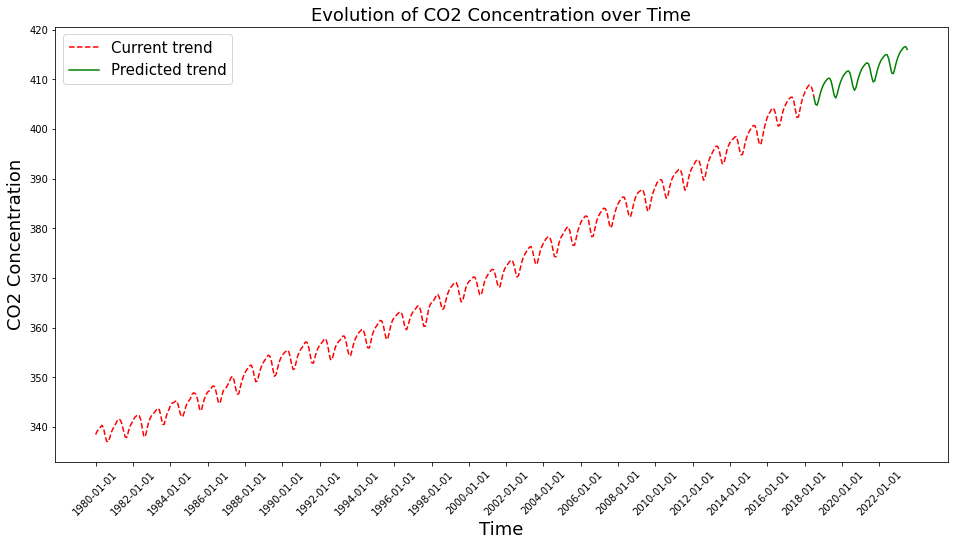

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the current and predicted trends
plt.figure(figsize=(16,8))

# Plotting the current trend
plt.plot(data['Average'], c='r', linestyle='--', label='Current trend')

# Creating a pd.Series from predictions
pred_ser = pd.Series(
    [data['Average'].values[-1]]+true_vals,
    index=[data.index[-1]]+[pd.to_datetime(data.index[-1], format="%Y-%m-%d")+pd.DateOffset(months=i+1) for i in range(60)]
)

pred_ser.index = pd.to_datetime(pred_ser.index).strftime('%Y-%m-%d')

# Plotting the predictions
plt.plot(pred_ser, c='g', label='Predicted trend')


#Annotating the plot
plt.xticks(np.arange(0, data["Average"].shape[0]+60, 24),rotation=45)
plt.xlabel('Time', fontsize=18)
plt.ylabel('CO2 Concentration', fontsize=18)
plt.legend(prop={'size': 15})
plt.title('Evolution of CO2 Concentration over Time', fontsize=18)